# Registration
This is a experimental notebook for registration using intensity-based rigid registration method with mutual information maximization. Sample CT images are in the same directory and the paths are hardcoded in this notebook.

In [1]:
import SimpleITK as sitk

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "./"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
# nii.gz format
#fixed_image = sitk.ReadImage("./volume-covid19-A-0700_day000.nii.gz", sitk.sitkFloat32)
#moving_image = sitk.ReadImage("./volume-covid19-A-0700_day007.nii.gz", sitk.sitkFloat32)

# Dicom format
fixed_reader = sitk.ImageSeriesReader()
fixed_dicom_names = fixed_reader.GetGDCMSeriesFileNames("./601.000000-COR 3X3-86740")
fixed_reader.SetFileNames(fixed_dicom_names)
fixed_image = fixed_reader.Execute()

moving_reader = sitk.ImageSeriesReader()
moving_dicom_names = moving_reader.GetGDCMSeriesFileNames("./604.000000-COR 3X3-11320")
moving_reader.SetFileNames(moving_dicom_names)
moving_image = moving_reader.Execute()

interact(
    display_images,
    fixed_image_z=(0, fixed_image.GetSize()[2] - 1),
    moving_image_z=(0, moving_image.GetSize()[2] - 1),
    fixed_npa=fixed(sitk.GetArrayViewFromImage(fixed_image)),
    moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)),
);

ImageSeriesReader (0x10bd6c680): Non uniform sampling or missing slices detected,  maximum nonuniformity:176.653

ImageSeriesReader (0x11cf8f6a0): Non uniform sampling or missing slices detected,  maximum nonuniformity:176.649



interactive(children=(IntSlider(value=52, description='fixed_image_z', max=105), IntSlider(value=55, descripti…

In [4]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
#    sitk.Euler3DTransform(),
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=52, description='image_z', max=105), FloatSlider(value=0.5, description=…

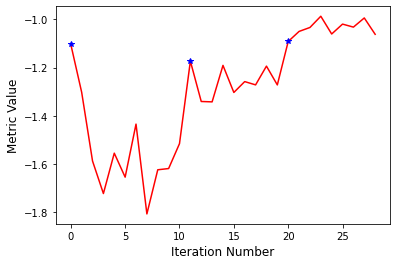

In [5]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [6]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

Final metric value: -1.0273658145200542
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [7]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

interactive(children=(IntSlider(value=52, description='image_z', max=105), FloatSlider(value=0.5, description=…

In [8]:
sitk.WriteImage(
    moving_resampled, os.path.join(OUTPUT_DIR, "604.000000-COR 3X3-11320_resampled.mha")
)
sitk.WriteTransform(
    final_transform, os.path.join(OUTPUT_DIR, "604.000000-COR 3X3-11320_T1.tfm")
)